In [6]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
    Resize,
    Compose,
    GaussNoise,
)
# from albumentations.torch import ToTensor
from torchvision.transforms import ToTensor
from training_segm import SIIMDataset, provider


warnings.filterwarnings("ignore")

In [7]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [8]:
import segmentation_models_pytorch as smp

In [22]:
# sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
# sample_submission_path = "../input/siim-stage1/sample_submission.csv"


train_rle_path = "./train-rle-100.csv"
sample_submission_path = "./train-rle-test-10-sample.csv"
test_rle_path = "./train-rle-test.csv"


data_folder = "./dicom_files"
test_data_folder = "./dicom_files"

In [9]:
dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=data_folder,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=4,
)

Creating dataset...


In [43]:
batch = next(iter(dataloader))  # get a batch from the dataloader
images, masks = batch

In [44]:
masks

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

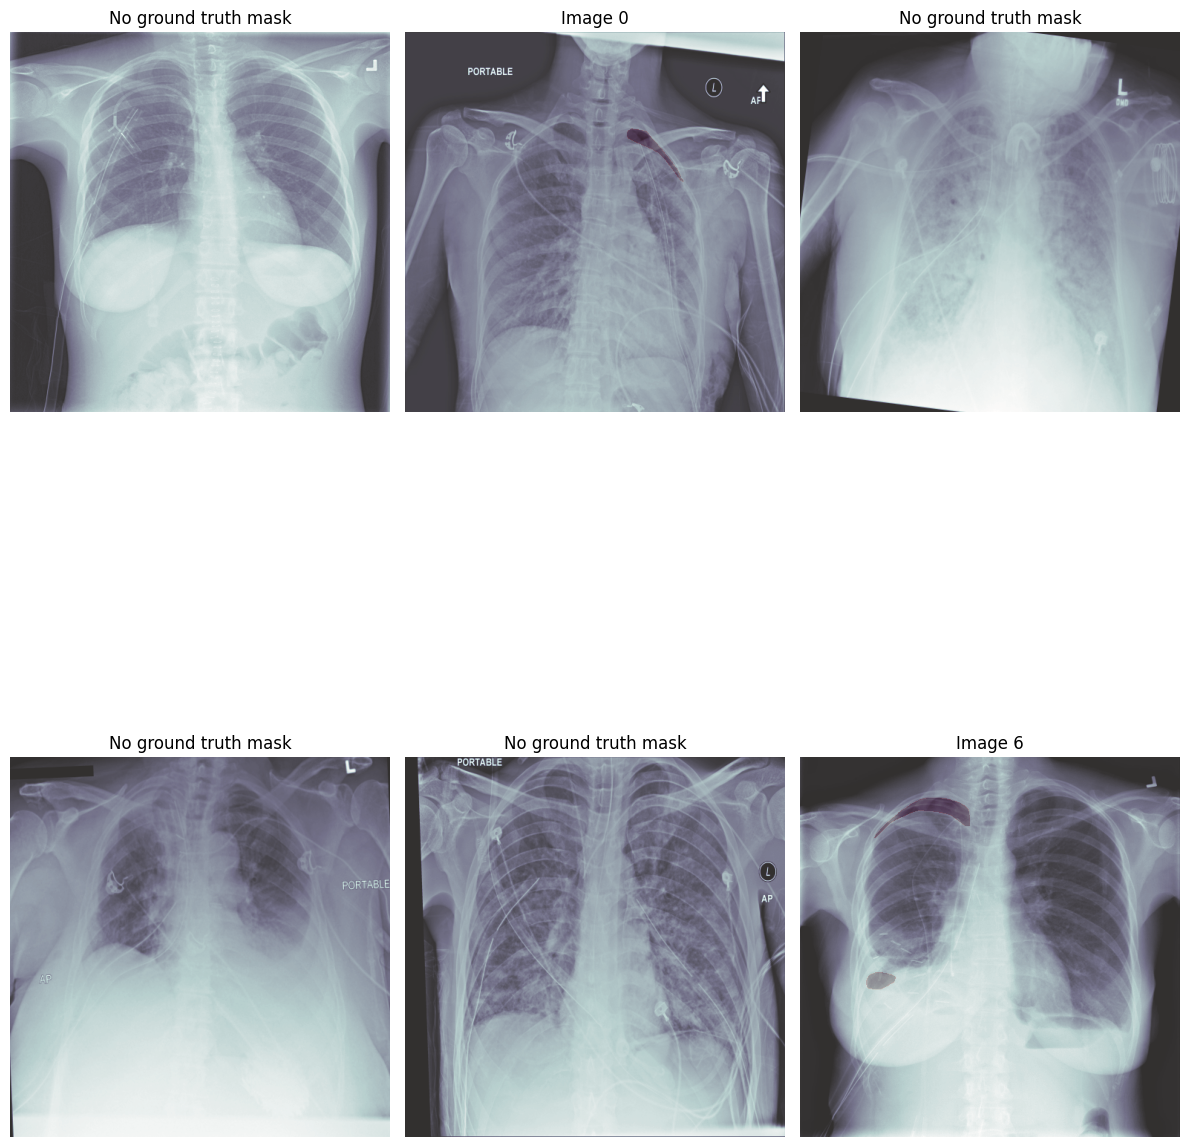

In [12]:
# # plot some random images in the `batch`
# idx = random.choice(range(16))
# plt.imshow(images[idx][0], cmap="bone")
# plt.imshow(masks[idx][0], alpha=0.2, cmap="Reds")
# plt.show()
# if len(np.unique(masks[idx][0])) == 1:  # only zeros

#     print("Chosen image has no ground truth mask, rerun the cell")

indices = random.sample(range(len(images)), 6)

fig, axes = plt.subplots(2, 3, figsize=(12, 18))  # Create a 3x2 grid for plotting

for ax, idx in zip(axes.flat, indices):
    ax.imshow(images[idx][0], cmap="bone")
    ax.imshow(masks[idx][0], alpha=0.2, cmap="Reds")
    ax.axis("off")

    if len(np.unique(masks[idx][0])) == 1:  # only zeros
        ax.set_title("No ground truth mask")
    else:
        ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()

In [13]:
len(masks)

16

In [14]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError(
                "Target size ({}) must be the same as input size ({})".format(
                    target.size(), input.size()
                )
            )
        max_val = (-input).clamp(min=0)
        loss = (
            input
            - input * target
            + max_val
            + ((-max_val).exp() + (-input - max_val).exp()).log()
        )
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha * self.focal(input, target) - torch.log(
            dice_loss(input, target)
        )
        return loss.mean()

In [15]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype("uint8")
    return preds


def metric(probability, truth, threshold=0.5, reduction="none"):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert probability.shape == truth.shape

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0).view(-1)
        pos_index = torch.nonzero(t_sum >= 1).view(-1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p * t).sum(-1) / ((p + t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice.tolist(), dice_neg.tolist(), dice_pos.tolist(), num_neg, num_pos


class Meter:
    """A meter to keep track of iou and dice scores throughout an epoch"""

    def __init__(self, phase, epoch):
        self.base_threshold = 0.5  # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    # def update(self, targets, outputs):
    #     probs = torch.sigmoid(outputs)
    #     dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
    #     self.base_dice_scores.extend(dice)
    #     self.dice_pos_scores.extend(dice_pos)
    #     self.dice_neg_scores.extend(dice_neg)
    #     preds = predict(probs, self.base_threshold)
    #     iou = compute_iou_batch(preds, targets, classes=[1])
    #     self.iou_scores.append(iou)
    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        print(self.base_dice_scores)
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou


def epoch_log(phase, epoch, epoch_loss, meter, start):
    """logging the metrics at the end of an epoch"""
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print(
        "Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f"
        % (epoch_loss, dice, dice_neg, dice_pos, iou)
    )
    return dice, iou


def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    """computes iou for one ground truth mask and predicted mask"""
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    """computes mean iou for a batch of ground truth masks and predicted masks"""
    ious = []
    preds = np.copy(outputs)  # copy is imp
    labels = np.array(labels)  # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

# UNet with ResNet34 model¶


In [12]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [17]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.backends.cudnn as cudnn
import time


class Trainer(object):
    """This class takes care of training and validation of our model"""

    def __init__(self, model):
        self.model = model
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size["train"]
        self.lr = 5e-4
        self.num_epochs = 2
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("mps")
        # self.device = torch.device("cuda:0")
        # torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode="min", patience=3, verbose=True
        )
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}

    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)  # .unsqueeze(1)  # (batch_size, 1, 512, 512)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches, desc=f"Epoch {epoch} [{phase}]")
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            # print(f"Batch {itr} - targets shape: {targets.shape}, outputs shape: {outputs.shape}")
            # targets = targets.unsqueeze(1)
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        # torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [19]:
model_trainer = Trainer(model)
model_trainer.start()
model_trainer.save_model("models/segmentation_restnet34_model.pth")

Creating dataset...
Creating dataset...
Starting epoch: 0 | phase: train | ⏰: 18:30:23


Epoch 0 [train]:   0%|          | 0/20 [00:00<?, ?it/s]ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/urllib/request.py", line 1354, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1256, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1302, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1251, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1011, in _send_output
    self.

[0.03944747522473335, 0.0, 0.0, 0.0, 0.021881233900785446, 0.02316388115286827, 0.0, 0.0, 0.03908570855855942, 0.014471258968114853, 0.01066659763455391, 0.0, 0.01609298214316368, 0.03905918076634407, 0.046409785747528076, 0.0, 0.046787112951278687, 0.0, 0.0, 0.0, 0.02599756419658661, 0.001732741016894579, 0.0, 0.0, 0.0023323106579482555, 0.036398936063051224, 0.0, 0.0, 0.023786189034581184, 0.05255476385354996, 0.003822270780801773, 0.0, 0.004423227626830339, 0.0, 0.0, 0.0, 0.019495995715260506, 0.012485701590776443, 0.0, 0.0, 0.011577557772397995, 0.1124560534954071, 0.04860766604542732, 0.0, 0.004098585806787014, 0.0030206027440726757, 0.0, 0.0, 0.02603956125676632, 0.007077166344970465, 0.0, 0.0, 0.14590542018413544, 0.0, 0.0, 0.0, 0.004157117567956448, 0.0, 0.0, 0.0, 0.009043412283062935, 0.0, 0.0, 0.0, 0.0018565953942015767, 0.01440188568085432, 0.0, 0.0, 0.08457687497138977, 0.004907700233161449, 0.014949004165828228, 0.0, 0.033864159137010574, 0.02625359036028385, 0.01900605298

Epoch 0 [val]:   0%|          | 0/5 [00:00<?, ?it/s]ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/urllib/request.py", line 1354, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1256, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1302, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1251, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1011, in _send_output
    self.sen

[0.034697674214839935, 0.02301741950213909, 0.11404696106910706, 0.0, 0.01804274320602417, 0.02980605699121952, 0.0, 0.0, 0.04211823269724846, 0.03477078303694725, 0.0, 0.0, 0.0005181508022360504, 0.0, 0.0, 0.0, 0.1370898336172104, 0.004285974893718958, 0.0, 0.0]
Loss: 7.1886 | dice: 0.0219 | dice_neg: 0.0000 | dice_pos: 0.0438 | IoU: 0.0200
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 18:32:59


Epoch 1 [train]:   0%|          | 0/20 [00:00<?, ?it/s]ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/urllib/request.py", line 1354, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1256, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1302, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1251, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/matteomondini/anaconda3/envs/med_imaging_env/lib/python3.8/http/client.py", line 1011, in _send_output
    self.

[0.0051343608647584915, 0.0, 0.0, 0.0, 0.016262467950582504, 0.04483608528971672, 0.0, 0.0, 0.0031182116363197565, 0.0049325767904520035, 0.06946761161088943, 0.0, 0.011778119951486588, 0.03301376849412918, 0.02917618490755558, 0.0, 0.02361953817307949, 0.012673168443143368, 0.0, 0.0, 0.034542761743068695, 0.02024117112159729, 0.0, 0.0, 0.050131477415561676, 0.02144172601401806, 0.019441798329353333, 0.0, 0.03149290755391121, 0.032480742782354355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20373691618442535, 0.05682414025068283, 0.0, 0.0, 0.007725761737674475, 0.06197107583284378, 0.015613866969943047, 0.0, 0.04249437153339386, 0.028503447771072388, 0.0, 0.0, 0.08447013795375824, 0.009208030998706818, 0.0, 0.0, 0.04375169426202774, 0.07241155952215195, 0.0, 0.0, 0.0017654848052188754, 0.018226295709609985, 0.0, 0.0, 0.05433386564254761, 0.13499069213867188, 0.005174259655177593, 0.0, 0.04324899986386299, 0.0037958621978759766, 0.0, 0.0, 0.006905080750584602, 0.021419303491711617, 0.0, 0.0, 0.0095

Epoch 1 [val]: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it, loss=1.2]  


[0.03170439228415489, 0.030162494629621506, 0.0, 0.0, 0.04243570938706398, 0.1688552051782608, 0.0, 0.0, 0.12001806497573853, 0.03560503199696541, 0.005310783162713051, 0.0, 0.078233502805233, 0.0, 0.0, 0.0, 0.044547189027071, 0.0014233447145670652, 0.0, 0.0]
Loss: 9.5811 | dice: 0.0279 | dice_neg: 0.0000 | dice_pos: 0.0558 | IoU: 0.0307

Model saved to models/segmentation_restnet34_model.pth


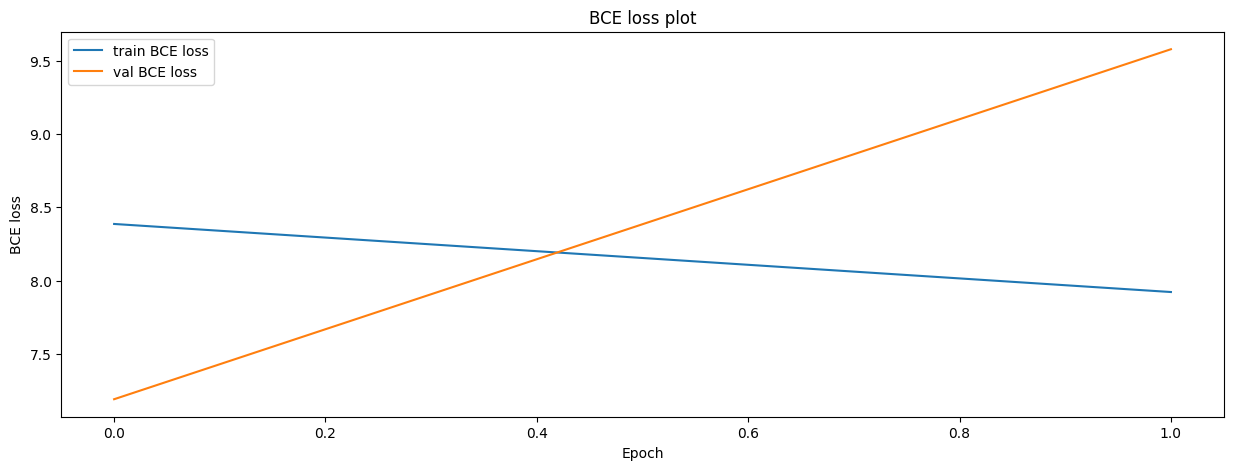

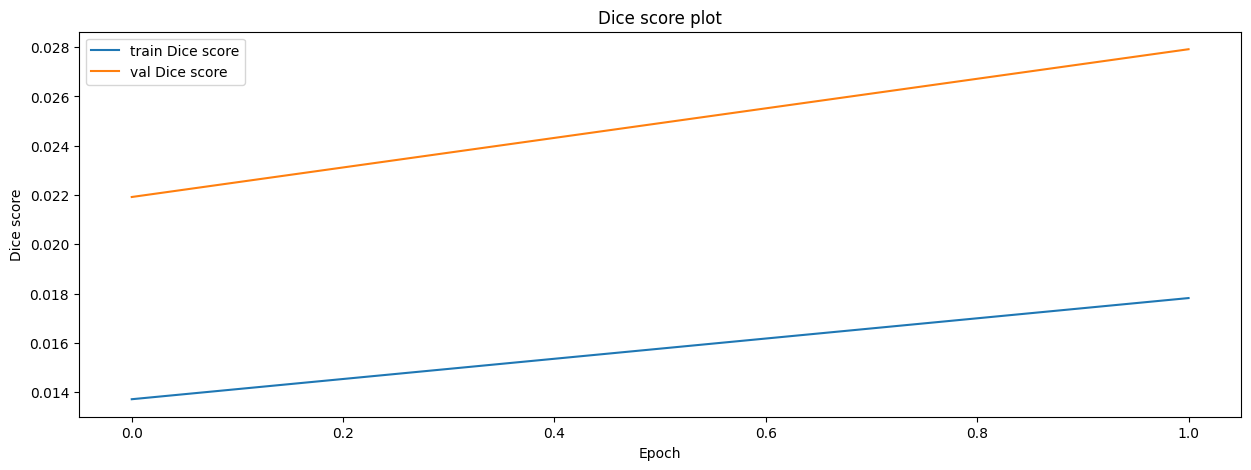

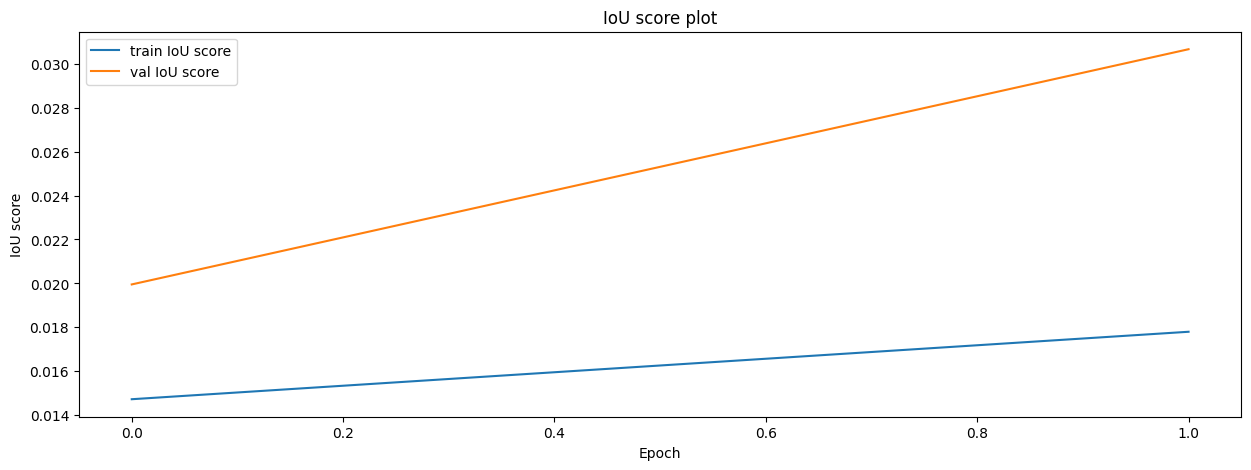

In [25]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores  # overall dice
iou_scores = model_trainer.iou_scores


def plot(scores, name):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f"train {name}")
    plt.plot(range(len(scores["train"])), scores["val"], label=f"val {name}")
    plt.title(f"{name} plot")
    plt.xlabel("Epoch")
    plt.ylabel(f"{name}")
    plt.legend()
    plt.show()


plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

# Testing segmentation

In [34]:
# from training_segm import run_length_encode
# from albumentations.pytorch import ToTensorV2


# sample_submission_path = "./train-rle-test-10-sample.csv"
# class TestDataset(Dataset):
#     def __init__(self, root, df, size, mean, std, tta=4):
#         self.root = root
#         self.size = size
#         self.fnames = list(df["ImageId"])
#         self.num_samples = len(self.fnames)
#         self.transform = Compose(
#             [
#                 Normalize(mean=mean, std=std, p=1),
#                 Resize(size, size),
#                 ToTensorV2(),
#             ]
#         )

#     def __getitem__(self, idx):
#         fname = self.fnames[idx]
#         path = os.path.join(self.root, fname + ".png")
#         image = cv2.imread(path)
#         images = self.transform(image=image)["image"]
#         return images

#     def __len__(self):
#         return self.num_samples


# def post_process(probability, threshold, min_size):
#     mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
#     num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
#     predictions = np.zeros((1024, 1024), np.float32)
#     num = 0
#     for c in range(1, num_component):
#         p = component == c
#         if p.sum() > min_size:
#             predictions[p] = 1
#             num += 1
#     return predictions, num

In [19]:
from testing_segm import TestDataset, run_length_encode, post_process

size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 4
batch_size = 16
best_threshold = 0.5
min_size = 3500
# device = torch.device("cuda:0")
device = torch.device("cpu")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
# model = model_trainer.net  # get the model from model_trainer object
model.eval()
state = torch.load("./model.pth", map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = (
        preds.detach().cpu().numpy()[:, 0, :, :]
    )  # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(
                probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR
            )
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append("-1")
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df["EncodedPixels"] = encoded_pixels
df.to_csv("submissiontest.csv", columns=["ImageId", "EncodedPixels"], index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

./dicom_files/1.2.276.0.7230010.3.1.4.8323329.388.1517875162.713279.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.12235.1517875238.124093.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.2808.1517875174.829184.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.11165.1517875231.492575.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.2131.1517875171.300904.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.11708.1517875234.399613.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.2131.1517875171.300904.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.13308.1517875244.605539.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.3335.1517875177.319000.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.3335.1517875177.319000.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.13341.1517875244.715918.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.1805.1517875169.650570.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.1805.1517875169.650570.dcm
./dicom_files/1.2.276.0.7230010.3.1.4.8323329.5

In [20]:
df


,ImageId,EncodedPixels,Unnamed: 2
0,1.2.276.0.7230010.3.1.4.8323329.388.1517875162...,-1,NaN
1,1.2.276.0.7230010.3.1.4.8323329.11165.15178752...,-1,NaN
2,1.2.276.0.7230010.3.1.4.8323329.2131.151787517...,-1,NaN
3,1.2.276.0.7230010.3.1.4.8323329.3335.151787517...,562296 4 1015 12 1009 15 1007 17 1005 20 1002 ...,NaN
4,1.2.276.0.7230010.3.1.4.8323329.1805.151787516...,-1,NaN
...,...,...,...
118,1.2.276.0.7230010.3.1.4.8323329.10557.15178752...,600176 10 1005 21 996 29 991 33 988 35 987 37 ...,NaN
119,1.2.276.0.7230010.3.1.4.8323329.10557.15178752...,600176 10 1005 21 996 29 991 33 988 35 987 37 ...,NaN
120,1.2.276.0.7230010.3.1.4.8323329.10557.15178752...,600176 10 1005 21 996 29 991 33 988 35 987 37 ...,NaN
121,1.2.276.0.7230010.3.1.4.8323329.11291.15178752...,-1,NaN


In [23]:
df_actual = pd.read_csv(test_rle_path)
df_actual.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.3342.151787517...,-1
1,1.2.276.0.7230010.3.1.4.8323329.5266.151787518...,-1
2,1.2.276.0.7230010.3.1.4.8323329.10912.15178752...,-1
3,1.2.276.0.7230010.3.1.4.8323329.4688.151787518...,-1
4,1.2.276.0.7230010.3.1.4.8323329.2556.151787517...,-1


In [25]:
df_merged = pd.merge(df, df_actual, on="ImageId", how="left", suffixes=("", "_actual"))
df_merged.rename(columns={"EncodedPixels_actual": "actual"}, inplace=True)

In [26]:
df_merged.head()

,ImageId,EncodedPixels,Unnamed: 2,actual
0,1.2.276.0.7230010.3.1.4.8323329.388.1517875162...,-1,NaN,-1
1,1.2.276.0.7230010.3.1.4.8323329.11165.15178752...,-1,NaN,-1
2,1.2.276.0.7230010.3.1.4.8323329.2131.151787517...,-1,NaN,261455 13 1005 21 998 28 994 31 991 34 988 36...
3,1.2.276.0.7230010.3.1.4.8323329.3335.151787517...,562296 4 1015 12 1009 15 1007 17 1005 20 1002 ...,NaN,584790 4 1017 7 1016 8 1014 11 1012 12 1012 1...
4,1.2.276.0.7230010.3.1.4.8323329.1805.151787516...,-1,NaN,606433 3 1018 6 1016 9 1013 11 1011 13 1009 1...


In [28]:
import numpy as np


def rle_decode(mask_rle, shape):
    """
    Decode run-length encoded string to a binary mask.
    Parameters:
    mask_rle (str): Run-length encoded string
    shape (tuple): Shape of the array to return (height, width)
    Returns:
    numpy.ndarray: Decoded binary mask
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [29]:
def dice_score(y_true, y_pred):
    """
    Calculate the Dice score between two binary masks.
    Parameters:
    y_true (numpy.ndarray): Ground truth binary mask
    y_pred (numpy.ndarray): Predicted binary mask
    Returns:
    float: Dice score
    """
    intersection = np.sum(y_true * y_pred)
    return (2.0 * intersection) / (np.sum(y_true) + np.sum(y_pred))

In [48]:
# Sample code assuming df_merged from the previous merge operation

# Define the shape of the masks (height, width)
mask_shape = (1024, 1024)  # example shape, adjust as needed


# Function to calculate Dice score for each row in the dataframe
def calculate_dice_score(row):
    if row["EncodedPixels"] == "-1" or row["actual"] == "-1":
        return 0.0  # No mask, return 0
    y_pred = rle_decode(row["EncodedPixels"], mask_shape)
    y_true = rle_decode(row["actual"], mask_shape)
    return dice_score(y_true, y_pred)


# Apply the function to each row and create a new column for Dice score
df_merged["dice_score"] = df_merged.apply(calculate_dice_score, axis=1)

df_merged[["ImageId", "EncodedPixels", "actual", "dice_score"]].head(10)

,ImageId,EncodedPixels,actual,dice_score
0,1.2.276.0.7230010.3.1.4.8323329.388.1517875162...,-1,-1,0.000000
1,1.2.276.0.7230010.3.1.4.8323329.11165.15178752...,-1,-1,0.000000
2,1.2.276.0.7230010.3.1.4.8323329.2131.151787517...,-1,261455 13 1005 21 998 28 994 31 991 34 988 36...,0.000000
3,1.2.276.0.7230010.3.1.4.8323329.3335.151787517...,562296 4 1015 12 1009 15 1007 17 1005 20 1002 ...,584790 4 1017 7 1016 8 1014 11 1012 12 1012 1...,0.864198
4,1.2.276.0.7230010.3.1.4.8323329.1805.151787516...,-1,606433 3 1018 6 1016 9 1013 11 1011 13 1009 1...,0.000000
5,1.2.276.0.7230010.3.1.4.8323329.32260.15178751...,142740 7 1005 23 991 34 983 41 978 45 976 48 9...,131584 7 1014 2 1016 2 1014 4 1012 5 993 21 9...,0.616114
6,1.2.276.0.7230010.3.1.4.8323329.1172.151787516...,-1,-1,0.000000
7,1.2.276.0.7230010.3.1.4.8323329.1723.151787516...,-1,-1,0.000000
8,1.2.276.0.7230010.3.1.4.8323329.32459.15178751...,-1,180804 24 997 35 985 41 973 53 963 64 949 76 ...,0.000000
9,1.2.276.0.7230010.3.1.4.8323329.4461.151787518...,-1,730625 1 1022 4 1020 7 1016 10 1015 12 1013 1...,0.000000


In [52]:
import pandas as pd
import numpy as np


# Function to decode RLE (Run-Length Encoding)
def rle_decode(mask_rle, shape):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# Function to calculate IoU (Jaccard Index)
def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(
        np.clip(y_true + y_pred, 0, 1)
    )  # Union is the sum of the clipped values
    return intersection / union


# Assuming the actual masks are stored in a dictionary with image ID as key
actual_masks = {
    "1.2.276.0.7230010.3.1.4.8323329.388.1517875162...": "actual_rle_string1",
    "1.2.276.0.7230010.3.1.4.8323329.11165.15178752...": "actual_rle_string2",
    # Add the rest of the actual masks here
}

# Load your DataFrame with predictions

# Add actual masks to the DataFrame
df["Actual"] = df["ImageId"].map(actual_masks)

# Initialize lists to store scores
iou_scores = []

# Define the shape of the images
image_shape = (1024, 1024)  # Example shape, adjust as needed

# Evaluate each prediction
for idx, row in df.iterrows():
    if row["EncodedPixels"] == "-1":
        predicted_mask = np.zeros(image_shape)
    else:
        predicted_mask = rle_decode(row["EncodedPixels"], image_shape)

    if row["Actual"] == "-1":
        actual_mask = np.zeros(image_shape)
    else:
        actual_mask = rle_decode(row["Actual"], image_shape)

    iou_score = jaccard_index(actual_mask, predicted_mask)
    iou_scores.append(iou_score)

# Add IoU scores to the DataFrame
df["IoUScore"] = iou_scores

# Calculate the mean IoU score
mean_iou_score = np.mean(
    [score for score in iou_scores if score > 0]
)  # Exclude cases where both are -1
print(f"Mean IoU Score: {mean_iou_score}")

AttributeError: 'float' object has no attribute 'split'

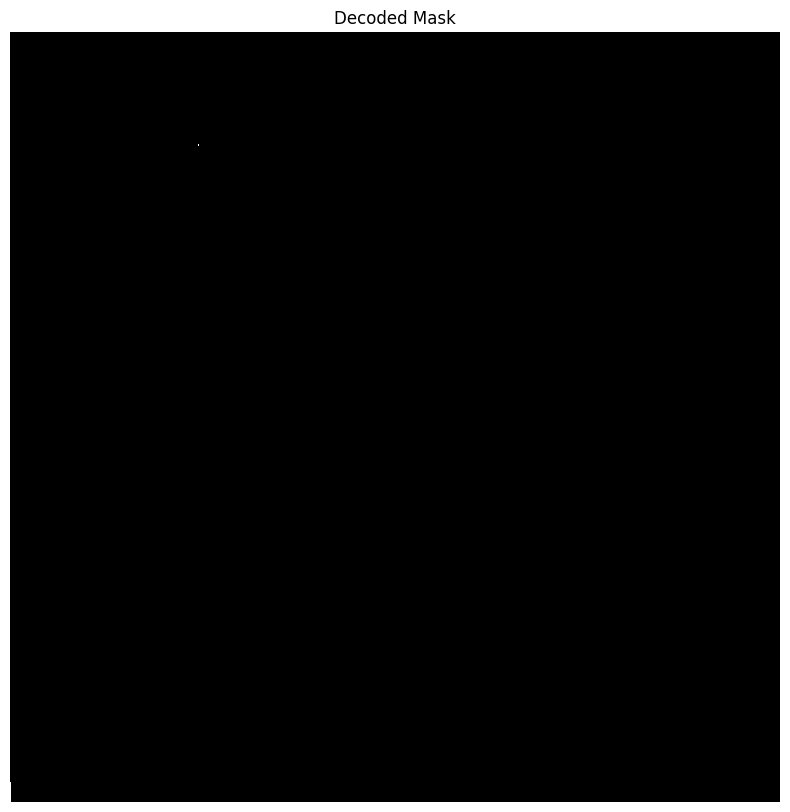

In [50]:
import numpy as np
import matplotlib.pyplot as plt


def rle_decode(mask_rle, shape=(1024, 1024)):
    """
    Decode run-length encoded string to a binary mask.
    Parameters:
    mask_rle (str): Run-length encoded string
    shape (tuple): Shape of the array to return (height, width)
    Returns:
    numpy.ndarray: Decoded binary mask
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1  # RLE encoding is 1-based index
    ends = starts + lengths
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    return mask.reshape(shape).T  # Transpose to match the expected orientation


# Example RLE string
rle_string = "256150 2 1019 6 1016 8 1015 10 1012 12 1011 13 1010 14 1008 16 1007 16 1007 17 1005 18 1005 19 1004 19 1005 18 1005 19 1004 19 1004 20 1004 20 1003 20 1003 20 1003 21 1003 20 1003 20 1003 20 1003 21 1003 20 1003 20 1003 21 1003 20 1003 21 1003 20 1003 21 1003 20 1003 21 1003 20 1003 21 1002 22 1002 21 1002 22 1002 21 1002 22 1002 21 1002 22 1001 22 1002 22 1001 23 1000 23 1001 22 1001 23 1001 22 1002 21 1002 22 1001 22 1002 22 1001 23 1000 23 1001 23 1000 23 1001 23 1000 24 1000 23 1000 24 999 24 1000 24 999 24 1000 24 999 24 1000 24 999 25 999 24 999 25 999 24 1000 24 999 24 999 25 999 24 999 25 998 26 998 25 998 26 998 25 999 25 998 25 999 25 998 25 999 25 998 26 998 25 998 25 999 25 999 24 999 24 1000 24 1000 23 1000 24 1000 24 1000 23 1000 24 1000 23 1001 23 1000 23 1001 23 1001 22 1002 22 1001 23 1001 22 1002 22 1001 22 1002 22 1002 22 1001 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1002 22 1003 21 1003 21 1004 19 1005 19 1005 19 1006 18 1006 18 1006 18 1006 18 1007 17 1007 17 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 16 1008 15 1009 15 1010 14 1010 14 1010 14 1010 14 1010 14 1011 13 1011 12 1013 10 1015 9 1017 5"

# Decode the RLE string
mask = rle_decode(rle_string, shape=(1024, 1024))

# Visualize the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap="gray", interpolation="nearest")
plt.title("Decoded Mask")
plt.axis("off")
plt.show()